### Import packages

In [14]:
import enchant
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import re
import spacy
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
import sys

In [2]:
# Install large model

#!{sys.executable} -m pip install "https://github.com/explosion/spacy-models/releases/download/en_core_web_lg-3.7.1/en_core_web_lg-3.7.1-py3-none-any.whl"
#!{sys.executable} -m spacy validate

# Do not use

In [3]:
# Install medium model
#!{sys.executable} -m pip install "https://github.com/explosion/spacy-models/releases/download/en_core_web_md-3.7.1/en_core_web_md-3.7.1-py3-none-any.whl"
#!{sys.executable} -m spacy validate

### Load and subset data

In [4]:
df = pd.read_csv("/home/domib/code/dominik-bulla/g0zzy/stress_sense/raw_data/Combined Data.csv", encoding="latin1")

In [5]:
df.columns

Index(['Unnamed: 0', 'statement', 'status'], dtype='object')

In [6]:
stress_posts = df[df['status'].isin(['Stress','Anxiety','Depression'])]
print(stress_posts.shape)
print(stress_posts.columns)
print(stress_posts.dtypes)
stress_posts.head(200)

(21961, 3)
Index(['Unnamed: 0', 'statement', 'status'], dtype='object')
Unnamed: 0     int64
statement     object
status        object
dtype: object


,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety
...,...,...,...
195,195,Do not compare yourself to others. Envy only m...,Anxiety
196,196,"The 5 dream ones were moved to a new unit, so ...",Anxiety
197,197,finished for the heart's intention to watch th...,Anxiety
198,198,"""No regrets or grudges/angry at things that ha...",Anxiety


### Text Preprocessing

In [7]:
### lowercase
### dealing with numbers, punctuation, and symbols
### splitting
### tokenizing
### removing "stopwords"
### lemmatizing

nlp = spacy.load("en_core_web_md", disable=["ner", "parser", "textcat"])

class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, language_model=nlp, min_len=1):
        self.nlp = language_model
        self.min_len = min_len  # optional length filter

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return [self._preprocess(x) for x in X]

    def _preprocess(self, text):
        # Missing values
        if text is None:
            return []
        if not isinstance(text, str):
            text = str(text)

        # lower case
        text = text.strip().lower()
        if not text:
            return []

        # dealing with numbers, punctuation, and symbols/stopwords/lemmatizing
        doc = self.nlp(text)
        tokens = [
            tok.lemma_
            for tok in doc
            if tok.is_alpha and not tok.is_stop
        ]

        doc = self.nlp(text)
        tokens = [
            tok.lemma_
            for tok in doc
            if tok.is_alpha
            and not tok.is_stop
            and len(tok) > 2         # drop very short leftovers
            and tok.lemma_ not in {"don", "t", "m", "feel", "like", "want", "know", "go", "think", "get"}  # custom contraction cleanup
        ]

        # Optional: drop very short results
        if len(tokens) < self.min_len:
            return []
        return tokens

text_pipeline = Pipeline([
    ("preprocessor", TextPreprocessor())
])


In [ ]:
processed = text_pipeline.fit_transform(stress_posts["statement"])
b = list(processed)  # in case it's a numpy array
stress_posts = stress_posts.copy()
stress_posts["processed_tokens"] = pd.Series(processed, index=stress_posts.index, dtype=object)
stress_posts.to_pickle("/home/domib/code/dominik-bulla/g0zzy/stress_sense/data/stress_posts.pkl")

### Text vectorizing

In [9]:
# use the pretokenized lists directly
vectorizer = CountVectorizer(
    analyzer=lambda x: x,   # identity analyzer: x is already a list of tokens
    lowercase=False,        # you already lowercased
    max_features=1000
)
vectorized_messages = vectorizer.fit_transform(stress_posts["processed_tokens"])

### Finding best model

In [10]:
scores = []
perplexities = []
topics_range = range(3, 21, 3)

for k in topics_range:
    print(k)
    lda = LatentDirichletAllocation(
        n_components=k,
        max_iter=100,
        random_state=42,
        learning_method="batch"
    )
    lda.fit(vectorized_messages)
    scores.append(lda.score(vectorized_messages))
    perplexities.append(lda.perplexity(vectorized_messages))

3
6
9
12
15
18


In [15]:
with open("../data/scores.pkl", "wb") as f:
    pickle.dump(scores, f)

with open("../data/perplexities.pkl", "wb") as f:
    pickle.dump(perplexities, f)

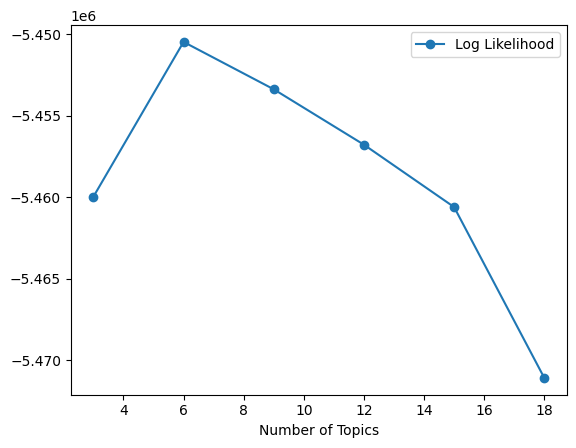

In [16]:
%matplotlib inline

plt.plot(topics_range, scores, marker="o", label="Log Likelihood")
# plt.plot(topics_range, perplexities, marker="x", label="Perplexity")
plt.xlabel("Number of Topics")
plt.legend()
plt.show()


### Train LDA Model

In [17]:
n_components = 6
lda_model = LatentDirichletAllocation(
    n_components=n_components,
    max_iter = 500,
    random_state=42)
lda_model.fit(vectorized_messages)
topics_mixture = lda_model.transform(vectorized_messages)

In [18]:
with open("../data/lda_model.pkl", "wb") as f:
    pickle.dump(lda_model, f)

In [19]:
np.save("../data/topics_mixture.npy", topics_mixture)


### link back to original dataframe 

In [20]:
def link_back(topics_mixture, stress_posts):

    topic_cols = [f"topic_{i}" for i in range(topics_mixture.shape[1])]
    topic_df = pd.DataFrame(topics_mixture, index=stress_posts.index, columns=topic_cols)

    stress_posts = stress_posts.copy()
    stress_posts["dominant_topic"] = topic_df.values.argmax(axis=1)
    stress_posts["dominant_weight"] = round(topic_df.max(axis=1),2)
    stress_posts["solution"] = np.where(
        stress_posts["dominant_weight"] > round(1/6,2), 1, 0
    )

    return stress_posts

In [21]:
stress_posts = link_back(topics_mixture, stress_posts)

In [23]:
### proportion of proper solutions
print(round(np.multiply(stress_posts.solution.value_counts(normalize=True)[1], 100),2))


99.08


In [24]:
stress_posts[
    (stress_posts['status'] == "Stress") &
    (stress_posts['solution'] == 1)
]["dominant_topic"].value_counts()


dominant_topic
0    561
2    483
4    480
1    458
3    455
5    146
Name: count, dtype: int64

In [25]:
def print_topics(lda_model, vectorizer, top_words):
    topic_word_mixture = pd.DataFrame(
        lda_model.components_,
        columns = vectorizer.get_feature_names_out()
    )
    n_components = topic_word_mixture.shape[0]

    for topic in range(n_components):
        print("-"*10)
        print(f"For topic {topic}, here are the the top {top_words} words with weights:")

        topic_df = topic_word_mixture.iloc[topic]\
            .sort_values(ascending = False).head(top_words)

        print(round(topic_df,3))

In [26]:
print_topics(lda_model, vectorizer, 20)


----------
For topic 0, here are the the top 20 words with weights:
depression    5567.643
help          4091.348
anxiety       3035.583
stress        1890.396
try           1759.515
mental        1726.219
therapy       1625.593
time          1551.503
health        1465.464
need          1457.554
work          1405.451
year          1391.307
take          1298.127
bad           1279.915
thing         1263.693
experience    1229.125
medication    1147.599
life          1078.450
therapist     1050.423
well          1048.960
Name: 0, dtype: float64
----------
For topic 1, here are the the top 20 words with weights:
tell      2271.214
mom       1987.162
year      1950.442
family    1595.627
parent    1518.385
leave     1510.872
day       1500.103
cry       1421.640
time      1296.881
say       1246.526
dad       1241.162
home      1224.074
come      1143.551
house     1117.086
need      1038.339
help      1016.711
live      1002.854
mother     984.161
room       936.125
night      933.585
